# **Introduction**

This notebook serves as an implementation of Soft Actor-Critic (SAC) on the custom-developed 2D navigation environment, titled ``Nav2D-v0``. The goal of this implementation is to quantify the performance of SAC in a simple 2D navigational  task, such that it can be used for incremental learning within subsequent environments.

# **Imports**

This section imports the necessary packages for this implementation.

In [8]:
# import gymnasium related packages:
import gymnasium as gym
from gymnasium.utils.env_checker import check_env
from gymnasium.wrappers import RescaleAction

# import custom environments and wrappers:
import nav2d

# import stablebaselines stuff:
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import Monitor, make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv

# other necessary imports:
from tqdm import tqdm
import pyautogui
import numpy as np
import pandas as pd
import os

# **Environment Definition and Hyperparameters**

This section defines and verifies the environment, defines the hyperparameters for the model, and creates a model.

In [9]:
# make the environment:
env = gym.make("Nav2D-v0")

# check the environment:
try: 
    check_env(env.unwrapped)
    print(f"Environment passes all checks!")
except Exception as e:
    print(f"Environment has the following issues: \n{e}")

Environment has the following issues: 9.33 | diff: 26.56 | rew_head: -0.15 | rew_dist: -0.33 | total: -0.87                                              
The `.np_random` is not properly been updated after step.


Evaluation function:

In [10]:
# this is the evaluation function:
def eval(env: gym.Env, 
         num_evals: int, 
         model):
    # reward list:
    eval_rew_hist = []

    # for each episode in the num_evals:
    for _ in range(num_evals):
        obs, _ = env.reset()
        done = False

        # initialize episodic reward:
        eval_rew = 0

        # while False:
        while not done:
            # get action and step:
            action, _ = model.predict(obs, deterministic = True)
            nobs, reward, term, trunc, _ = env.step(action)
            done = term or trunc
            
            # advance reward:
            eval_rew += reward

            # advance observation, reset if not:
            obs = nobs if not done else env.reset()
    
        # append:
        eval_rew_hist.append(eval_rew)

    return np.mean(eval_rew_hist).round(3)

Define hyperparameters:

In [11]:
# hyperparameters:
policy = "MlpPolicy"
gamma = 0.99
learning_rate = 3e-4
buffer_size = int(1e6)
batch_size = 64
tau = 5e-3
ent_coef = "auto_0.1"
train_freq = 1
learning_starts = int(0)
target_update_interval = 1
gradient_steps = 4
target_entropy = "auto"
action_noise = None
verbose = 0

# vectorize or nah:
vectorize = True
n_envs = 16
render_mode = "human"

Make envs:

In [12]:
# make environment based on whether to vectorize or not:
env = gym.make("Nav2D-v0", max_episode_steps = 1000, render_mode = render_mode) if not vectorize else make_vec_env("Nav2D-v0", n_envs = n_envs, vec_env_cls = DummyVecEnv)

# evaluation environment:
eval_env = gym.make("Nav2D-v0", max_episode_steps = 1000, render_mode = "rgb_array")

Create model:

In [13]:
# model creation using SB3:
model = SAC(policy = policy, 
            env = env,
            learning_rate = learning_rate,
            buffer_size = buffer_size,
            batch_size = batch_size,
            tau = tau,
            ent_coef = ent_coef,
            train_freq = train_freq,
            learning_starts = learning_starts,
            target_update_interval = target_update_interval,
            gradient_steps = gradient_steps,
            target_entropy = target_entropy,
            action_noise = action_noise, 
            verbose = verbose)

print(type(model))

<class 'stable_baselines3.sac.sac.SAC'>


# **Train the model**

Using the instantiated SB3 model, train on the ``Nav2D-v0`` environment.

In [ ]:
# run parameters:
number_of_runs = 100
steps_per_run = 25000
num_evals = 10

# initialize the total reward:
total_reward = []

# model saving parameters:
base_path = os.path.join(os.getcwd(), "Nav2D_SAC_SB3_results")
results_path = os.path.join(base_path, f"result_{len(os.listdir(base_path)) + 1}")
os.makedirs(results_path, exist_ok = True)

# using model.learn approach:
for run in tqdm(range(number_of_runs), ncols = 100, colour = "#33FF00", desc = "training progress"):
    # learn every run:
    model.learn(total_timesteps = steps_per_run, reset_num_timesteps = False)

    # evaluate and save every 10th run:
    if run % 10 == 0:
        # after learning:
        eval_reward = eval(eval_env, num_evals = num_evals, model = model)

        # append the eval reward to the total reward:
        total_reward.append(eval_reward)

        # save the model to this directory:
        model.save(os.path.join(results_path, f"run_{run+1}"))

# close environment when done:
env.close()

training progress:   0%|                                                    | 0/100 [00:00<?, ?it/s]

c:\Users\mtidd2\Desktop\ROS2_DRL_Navigation\.venv\Lib\site-packages\gymnasium\utils\passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


training progress:   1%|▍                                         | 1/100 [00:54<1:29:12, 54.07s/it]

training progress:   2%|▊                                         | 2/100 [01:53<1:33:00, 56.95s/it]

training progress:   3%|█▎                                        | 3/100 [02:47<1:29:53, 55.60s/it]

training progress:   4%|█▋                                        | 4/100 [03:39<1:26:59, 54.37s/it]

training progress:   5%|██                                        | 5/100 [04:32<1:25:21, 53.91s/it]

training progress:   6%|██▌                                       | 6/100 [05:27<1:24:45, 54.11s/it]

training progress:   7%|██▉                                       | 7/100 [06:22<1:24:41, 54.64s/it]

training progress:   8%|███▎                                      | 8/100 [07:18<1:24:31, 55.12s/it]

training progress:   9%|███▊                                      | 9/100 [08:17<1:25:21, 56.28s/it]

training progress:  10%|████                                     | 10/100 [09:16<1:25:19, 56.89s/it]

training progress:  11%|████▌                                    | 11/100 [10:15<1:25:23, 57.57s/it]

training progress:  12%|████▉                                    | 12/100 [11:14<1:25:21, 58.20s/it]

training progress:  13%|█████▎                                   | 13/100 [12:14<1:25:05, 58.68s/it]

training progress:  14%|█████▋                                   | 14/100 [13:13<1:24:07, 58.69s/it]

training progress:  15%|██████▏                                  | 15/100 [14:11<1:23:07, 58.68s/it]

training progress:  16%|██████▌                                  | 16/100 [15:11<1:22:22, 58.84s/it]

training progress:  17%|██████▉                                  | 17/100 [16:11<1:21:52, 59.19s/it]

training progress:  18%|███████▍                                 | 18/100 [17:09<1:20:36, 58.99s/it]

training progress:  19%|███████▊                                 | 19/100 [18:08<1:19:33, 58.93s/it]

training progress:  20%|████████▏                                | 20/100 [19:07<1:18:27, 58.85s/it]

training progress:  21%|████████▌                                | 21/100 [20:05<1:17:24, 58.79s/it]

training progress:  22%|█████████                                | 22/100 [21:06<1:17:15, 59.42s/it]

training progress:  23%|█████████▍                               | 23/100 [22:05<1:16:12, 59.38s/it]

training progress:  24%|█████████▊                               | 24/100 [23:04<1:14:59, 59.20s/it]

training progress:  25%|██████████▎                              | 25/100 [24:02<1:13:31, 58.82s/it]

training progress:  26%|██████████▋                              | 26/100 [25:00<1:12:03, 58.43s/it]

training progress:  27%|███████████                              | 27/100 [25:58<1:11:07, 58.46s/it]

training progress:  28%|███████████▍                             | 28/100 [26:56<1:09:51, 58.21s/it]

training progress:  29%|███████████▉                             | 29/100 [27:52<1:08:16, 57.69s/it]

training progress:  30%|████████████▎                            | 30/100 [28:51<1:07:45, 58.08s/it]

training progress:  31%|████████████▋                            | 31/100 [29:50<1:07:00, 58.27s/it]

training progress:  32%|█████████████                            | 32/100 [30:50<1:06:26, 58.63s/it]

training progress:  33%|█████████████▌                           | 33/100 [31:49<1:05:51, 58.98s/it]

training progress:  34%|█████████████▉                           | 34/100 [32:48<1:04:48, 58.92s/it]

training progress:  35%|██████████████▎                          | 35/100 [33:46<1:03:32, 58.65s/it]

training progress:  36%|██████████████▊                          | 36/100 [34:46<1:02:53, 58.95s/it]

training progress:  37%|███████████████▏                         | 37/100 [35:44<1:01:48, 58.87s/it]

training progress:  38%|███████████████▌                         | 38/100 [36:43<1:00:46, 58.81s/it]

training progress:  39%|████████████████▊                          | 39/100 [37:42<59:43, 58.74s/it]

training progress:  40%|█████████████████▏                         | 40/100 [38:41<58:57, 58.96s/it]

training progress:  41%|█████████████████▋                         | 41/100 [39:40<57:50, 58.83s/it]

training progress:  42%|██████████████████                         | 42/100 [40:40<57:08, 59.12s/it]

training progress:  43%|██████████████████▍                        | 43/100 [41:40<56:28, 59.46s/it]

training progress:  44%|██████████████████▉                        | 44/100 [42:40<55:45, 59.74s/it]

training progress:  45%|███████████████████▎                       | 45/100 [43:39<54:23, 59.33s/it]

training progress:  46%|███████████████████▊                       | 46/100 [44:38<53:22, 59.30s/it]

training progress:  47%|████████████████████▏                      | 47/100 [45:37<52:24, 59.32s/it]

training progress:  48%|████████████████████▋                      | 48/100 [46:37<51:35, 59.53s/it]

training progress:  49%|█████████████████████                      | 49/100 [47:38<50:49, 59.80s/it]

training progress:  50%|█████████████████████▌                     | 50/100 [48:39<50:08, 60.17s/it]

training progress:  51%|█████████████████████▉                     | 51/100 [49:38<48:59, 59.98s/it]

training progress:  52%|██████████████████████▎                    | 52/100 [50:37<47:48, 59.75s/it]

training progress:  53%|██████████████████████▊                    | 53/100 [51:38<46:55, 59.91s/it]

training progress:  54%|███████████████████████▏                   | 54/100 [52:37<45:43, 59.64s/it]

training progress:  55%|███████████████████████▋                   | 55/100 [53:37<44:57, 59.94s/it]

training progress:  56%|████████████████████████                   | 56/100 [54:36<43:36, 59.46s/it]

training progress:  57%|████████████████████████▌                  | 57/100 [55:35<42:40, 59.55s/it]

training progress:  58%|████████████████████████▉                  | 58/100 [56:35<41:35, 59.42s/it]

training progress:  59%|█████████████████████████▎                 | 59/100 [57:34<40:33, 59.36s/it]

training progress:  60%|█████████████████████████▊                 | 60/100 [58:34<39:44, 59.60s/it]

training progress:  61%|██████████████████████████▏                | 61/100 [59:34<38:52, 59.82s/it]

training progress:  62%|█████████████████████████▍               | 62/100 [1:00:34<37:49, 59.72s/it]

training progress:  63%|█████████████████████████▊               | 63/100 [1:01:33<36:47, 59.67s/it]

training progress:  64%|██████████████████████████▏              | 64/100 [1:02:32<35:35, 59.33s/it]

training progress:  65%|██████████████████████████▋              | 65/100 [1:03:31<34:39, 59.40s/it]

training progress:  66%|███████████████████████████              | 66/100 [1:04:30<33:32, 59.18s/it]

training progress:  67%|███████████████████████████▍             | 67/100 [1:05:29<32:35, 59.25s/it]

training progress:  68%|███████████████████████████▉             | 68/100 [1:06:29<31:35, 59.24s/it]

training progress:  69%|████████████████████████████▎            | 69/100 [1:07:28<30:40, 59.38s/it]

training progress:  70%|████████████████████████████▋            | 70/100 [1:08:30<30:02, 60.09s/it]

training progress:  71%|█████████████████████████████            | 71/100 [1:09:31<29:05, 60.19s/it]

training progress:  72%|█████████████████████████████▌           | 72/100 [1:10:30<27:58, 59.95s/it]

training progress:  73%|█████████████████████████████▉           | 73/100 [1:11:31<27:09, 60.34s/it]

training progress:  74%|██████████████████████████████▎          | 74/100 [1:12:32<26:11, 60.45s/it]

training progress:  75%|██████████████████████████████▊          | 75/100 [1:13:32<25:05, 60.22s/it]

training progress:  76%|███████████████████████████████▏         | 76/100 [1:14:30<23:54, 59.77s/it]

training progress:  77%|███████████████████████████████▌         | 77/100 [1:15:31<23:01, 60.06s/it]

training progress:  78%|███████████████████████████████▉         | 78/100 [1:16:32<22:06, 60.28s/it]

training progress:  79%|████████████████████████████████▍        | 79/100 [1:17:31<20:59, 59.97s/it]

training progress:  80%|████████████████████████████████▊        | 80/100 [1:18:31<20:01, 60.10s/it]

training progress:  81%|█████████████████████████████████▏       | 81/100 [1:19:32<19:06, 60.33s/it]

training progress:  82%|█████████████████████████████████▌       | 82/100 [1:20:32<18:03, 60.20s/it]

training progress:  83%|██████████████████████████████████       | 83/100 [1:21:32<17:02, 60.15s/it]

training progress:  84%|██████████████████████████████████▍      | 84/100 [1:22:34<16:08, 60.56s/it]

training progress:  85%|██████████████████████████████████▊      | 85/100 [1:23:33<15:01, 60.13s/it]

training progress:  86%|███████████████████████████████████▎     | 86/100 [1:24:33<14:02, 60.16s/it]

training progress:  87%|███████████████████████████████████▋     | 87/100 [1:25:34<13:04, 60.35s/it]

training progress:  88%|████████████████████████████████████     | 88/100 [1:26:34<12:02, 60.19s/it]

training progress:  89%|████████████████████████████████████▍    | 89/100 [1:27:33<10:58, 59.82s/it]

training progress:  90%|████████████████████████████████████▉    | 90/100 [1:28:33<09:58, 59.89s/it]

training progress:  91%|█████████████████████████████████████▎   | 91/100 [1:29:33<09:00, 60.09s/it]

training progress:  92%|█████████████████████████████████████▋   | 92/100 [1:30:35<08:04, 60.57s/it]

training progress:  93%|██████████████████████████████████████▏  | 93/100 [1:31:37<07:06, 60.94s/it]

training progress:  94%|██████████████████████████████████████▌  | 94/100 [1:32:37<06:03, 60.60s/it]

training progress:  95%|██████████████████████████████████████▉  | 95/100 [1:33:37<05:02, 60.56s/it]

training progress:  96%|███████████████████████████████████████▎ | 96/100 [1:34:37<04:01, 60.42s/it]

training progress:  97%|███████████████████████████████████████▊ | 97/100 [1:35:37<03:00, 60.33s/it]

training progress:  98%|████████████████████████████████████████▏| 98/100 [1:36:39<02:01, 60.89s/it]

training progress:  99%|████████████████████████████████████████▌| 99/100 [1:37:39<01:00, 60.62s/it]

training progress: 100%|████████████████████████████████████████| 100/100 [1:38:41<00:00, 59.22s/it]

[np.float64(-673.016), np.float64(-646.951), np.float64(-618.236), np.float64(-663.386), np.float64(-609.652), np.float64(-632.228), np.float64(-638.35), np.float64(-722.159), np.float64(-1116.104), np.float64(-864.577), np.float64(-882.999), np.float64(-1075.531), np.float64(-1130.52), np.float64(-1039.316), np.float64(-1207.833), np.float64(-859.517), np.float64(-1414.396), np.float64(-746.353), np.float64(-765.646), np.float64(-1113.237), np.float64(-870.53), np.float64(-854.741), np.float64(-1347.378), np.float64(-1069.91), np.float64(-1392.538), np.float64(-677.687), np.float64(-947.162), np.float64(-878.057), np.float64(-701.507), np.float64(-1075.221), np.float64(-1307.72), np.float64(-795.624), np.float64(-1069.526), np.float64(-959.129), np.float64(-910.816), np.float64(-1217.961), np.float64(-981.521), np.float64(-611.576), np.float64(-783.611), np.float64(-1137.664), np.float64(-1259.56), np.float64(-1102.799), np.float64(-941.327), np.float64(-1204.434), np.float64(-861.312

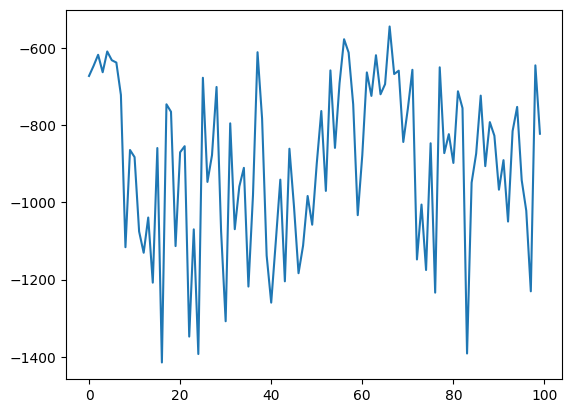

In [15]:
print(total_reward)
import matplotlib.pyplot as plt

plt.plot(total_reward)
plt.show()

In [16]:
# if mujoco is angry:
env.close()

# **Visualization**

This section visualizes the learned policy.

In [ ]:
visualize = False
testing_length = 1

if visualize:
    # render settings:
    width = 1280
    height = 1280
    default_camera_config = {"azimuth" : 90.0, "elevation" : -90.0, "distance" : 3, "lookat" : [0.0, 0.0, 0.0]}
    camera_id = 2

    DEFAULT_CAMERA = "overhead_camera"
    ENABLE_FRAME = True
    RENDER_EVERY_FRAME = True 

    # make a single environment:
    env = gym.make("Nav2D-v0", 
                render_mode = "human", 
                width = width, 
                height = height,
                default_camera_config = default_camera_config, 
                camera_id = camera_id, 
                max_episode_steps = 1000)

    if DEFAULT_CAMERA=="overhead_camera": pyautogui.press('tab')
    if ENABLE_FRAME: pyautogui.press('e') 
    if not RENDER_EVERY_FRAME: pyautogui.press('d') 

    # for every test episode:
    for eps in range(testing_length):
        obs, _ = env.reset()
        done = False

        # while not done:
        while not done:
            action, _ = model.predict(obs, deterministic = True)
            nobs, reward, term, trunc, _ = env.step(action)
            done = term or trunc

            # advance observation, reset if not:
            obs = nobs if not done else env.reset()
            
            # render for user:
            env.render()

    # close when done:
    env.close()